# Expanding Regression Residual Backtest

Expanding out-of-sample regression

## Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from   statsmodels.regression.rolling import RollingOLS

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\TreasuryInflationPCA\root\src")
from PCSpreadOLS import PCASpreadOLS

In [6]:
def _get_expanding(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_tmp = (df.set_index(
        "date").
        sort_index().
        dropna())
    
    model = (RollingOLS(
        endog     = df_tmp.PX_bps,
        exog      = sm.add_constant(df_tmp.spread),
        expanding = True).
        fit())
    
    df_out = (model.params.rename(columns = {
        "const"     : "alpha",
        "spread": "beta"}).
        merge(right = df_tmp, how = "inner", on = ["date"]).
        sort_index().
        assign(
            resid     =  lambda x: (x.beta * x.lag_spread) + x.alpha,
            lag_resid =  lambda x: x.resid.shift(),
            signal_rtn = lambda x: np.sign(x.lag_resid) * x.PX_bps).
        dropna())
    
    return df_out

def get_expanding_ols() -> pd.DataFrame: 

    df_prep = (PCASpreadOLS().pca_signal().drop(
        columns = ["inflation", "breakeven"]).
        merge(right = PCASpreadOLS().get_tsy_fut(), how = "inner", on = ["date"]).
        drop(columns = ["PX_rtn", "PX_diff", "PX_cnvx", "PX_dur", "PX_LAST"]).
        assign(
            security  = lambda x: x.security.str.split(" ").str[0],
            group_var = lambda x: x.security + " " + x.input_val + " " + x.variable))

    df_out = (df_prep.groupby(
        "group_var").
        apply(_get_expanding).
        drop(columns = ["group_var"]).
        reset_index())
    
    return df_out

df_expanding = get_expanding_ols()

C:\Users\Diego\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  s2 = ssr / (nobs - tot_params)
C:\Users\Diego\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  s2 = ssr / (nobs - tot_params)
C:\Users\Diego\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  s2 = ssr / (nobs - tot_params)
C:\Users\Diego\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  s2 = ssr / (nobs - tot_params)
C:\Users\Diego\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  s2 = ssr / (nobs - tot_params)
C:\Users\Diego\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encount

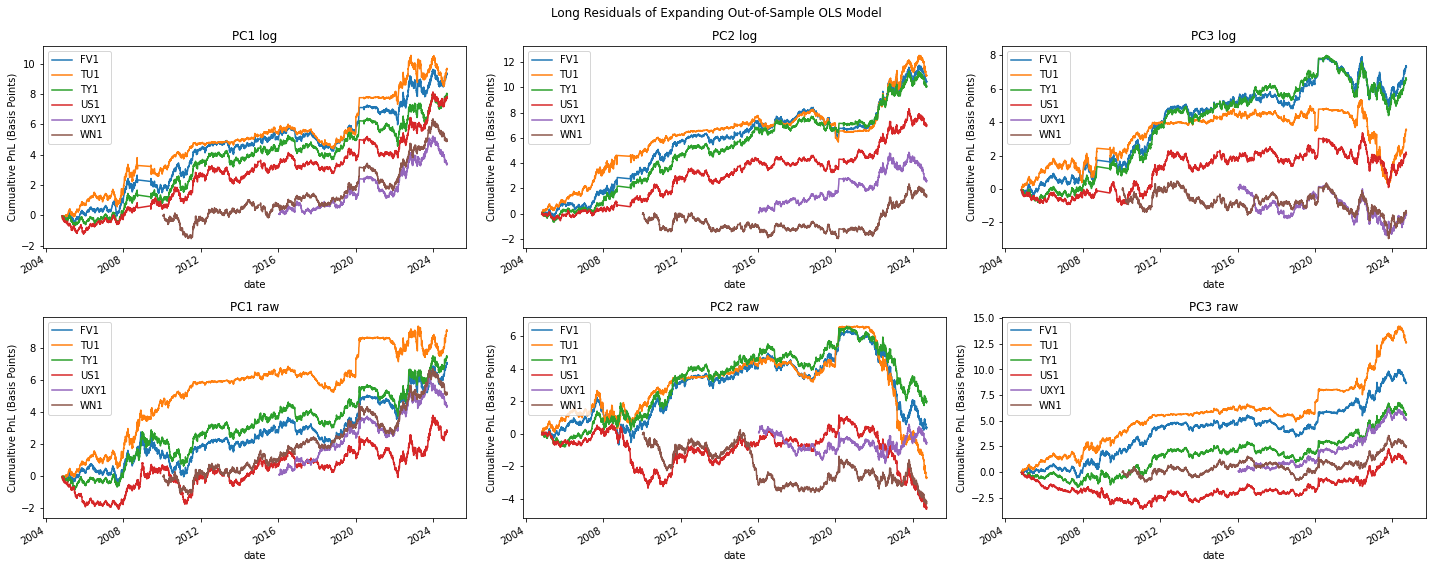

In [7]:
def plot_returns(df: pd.DataFrame) -> plt.Figure:
    
    df_plot = (df.drop(
        columns = ["group_var"]).
        assign(group_var = lambda x: x.variable + " " + x.input_val))

    variables = df_plot.group_var.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(variables) // 2, nrows = len(variables) // 3, figsize = (20,8))

    for variable, ax in zip(variables, axes.flatten()):

        (df_plot.query(
            "group_var == @variable").
            rename(columns = {"security": ""}).
            pivot(index = "date", columns = "", values = "signal_rtn").
            cumsum().
            plot(
                ax     = ax,
                title  = variable.split("_")[0],
                ylabel = "Cumualtive PnL (Basis Points)"))

    fig.suptitle("Long Residuals of Expanding Out-of-Sample OLS Model")
    plt.tight_layout()
    
plot_returns(df_expanding)

In [8]:
def get_sharpe(df: pd.DataFrame) -> pd.DataFrame:
    
    df_tmp = (df.drop(
        columns = ["group_var"]).
        assign(group_var = lambda x: x.variable + " " + x.input_val))

    df_sharpe = (df_tmp[
        ["group_var", "security", "signal_rtn"]].
        groupby(["group_var", "security"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_sharpe

df_sharpe = get_sharpe(df_expanding)

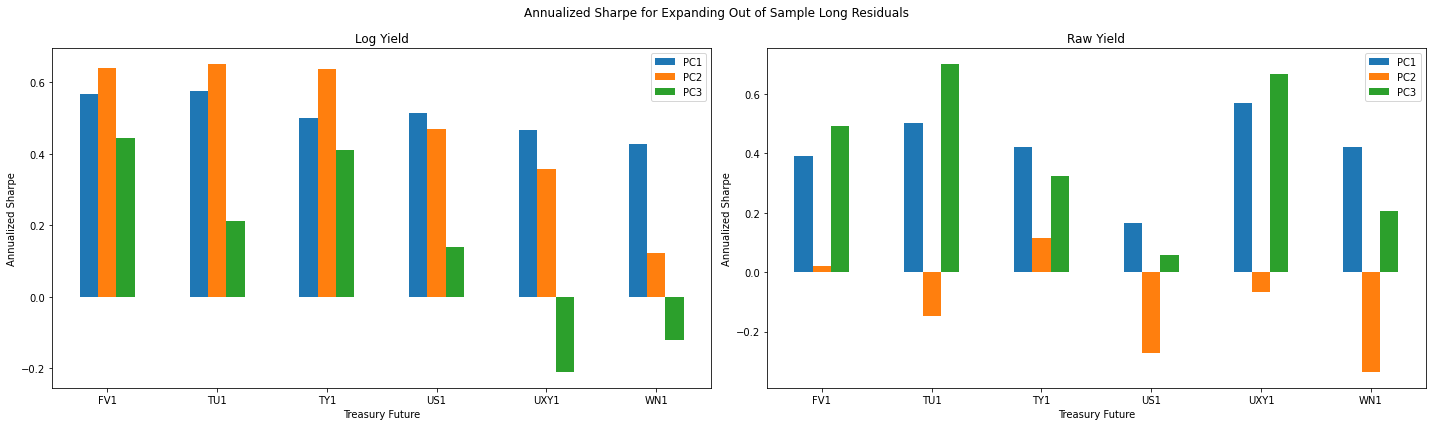

In [10]:
def plot_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    df_plot = (df_sharpe.assign(
        pc        = lambda x: x.group_var.str.split(" ").str[0],
        input_val = lambda x: x.group_var.str.split(" ").str[1]))

    variables = df_plot.input_val.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))

    for variable, ax in zip(variables, axes.flatten()):

        (df_plot.query(
            "input_val == @variable").
            rename(columns = {"pc": ""}).
            pivot(index = "security", columns = "", values = "sharpe").
            plot(
                kind   = "bar",
                ax     = ax,
                xlabel = "Treasury Future",
                rot    = 0,
                ylabel = "Annualized Sharpe",
                title  = variable.split("_")[0].capitalize() + " Yield"))
        
    fig.suptitle("Annualized Sharpe for Expanding Out of Sample Long Residuals")
    plt.tight_layout()
        
plot_sharpe(df_sharpe)